In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import plot, show, savefig, xlim, figure,  ylim, legend, boxplot, setp, axes

import copy

from sklearn.cluster import Birch
from sklearn import metrics
from sklearn.metrics import pairwise_distances

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

import collections
@ignore_warnings(category=ConvergenceWarning)

def get_cal_score(data, labels):
    return metrics.calinski_harabasz_score(data, labels)

/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
df = pd.read_csv('data.csv')
df.shape


(288, 7)

In [3]:
columns = list(df.columns)
columns

['index',
 'totalCarNumber',
 'numberOfTrips',
 'median_overhead',
 'q1_overhead',
 'q3_overhead',
 'p9_overhead']

In [4]:
df_before =df#.iloc[:144, :]


indexes = np.array_split(df_before.index,16, axis=0)
for i,index in enumerate(indexes):
    df_before.loc[index,'group'] = i
    
df_before['c'] = df_before['group'].diff()
df_filtered = df_before[df_before['c'] != 0]

index_list = df_filtered.index.tolist() # list of the start poisitions of index for change of values 
# print(len(index_list))
# print('\n')
# print(index_list)

l_mod = index_list + [max(index_list)+1] # creating a list of indexes to iterate over (must have 0 in it)
list_of_dfs = [df_before.iloc[l_mod[n]:l_mod[n+1]] for n in range(len(l_mod)-1)] # creating a list of dfs for each index

# len(list_of_dfs)

In [5]:
def plot_silhouette_scores(model, test_data, n_clusters_min, n_clusters_max, title):
    """ Plot silhouette scores and return the best number of clusters"""

    if len(model.subcluster_labels_) >= 2:

        silhouette_scores = []
        clusters_range = range(n_clusters_min, n_clusters_max+1)
        results_dict = []
        for number in clusters_range:
            # make a copy of the model so as not to mess up the 'correct' model
            model_cpy = copy.deepcopy(model)
            model_cpy.set_params(n_clusters=number)

            model_cpy.partial_fit()
            labels = model_cpy.predict(test_data)
            try: 
                s = metrics.silhouette_score(test_data, labels, metric='euclidean')
                silhouette_scores.append(s)
                results_dict.append((number, s))
            except ValueError:
                pass

        silhouette_range = [i[0] for i in results_dict]  
        max_score = max(silhouette_scores)
        for i in results_dict:
            if i[1] == max_score:
                print(max_score)
                return int(i[0])
    else:
        print(0)
        return n_clusters_min

In [6]:
def combine_dfs(df_list):
    return pd.concat(df_list)

In [7]:
def outliers_removal(df):
    data_split_modified_z = df[['median_overhead', 'q1_overhead', 'q3_overhead', 'p9_overhead', 'totalCarNumber', 'index']].copy()
    # to_drop = [252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264,265,266]
    # data_split_modified_z.drop(to_drop, inplace=True)
#     data_split_modified_z = data_split_modified_z.iloc[:144, :]
    data_split_modified_z = data_split_modified_z.to_numpy()
    data_split_modified_z_12 = np.split(data_split_modified_z, 1)
    indexes = [] 

    for d in range(len(data_split_modified_z_12)):
        ind = []
        k = len(data_split_modified_z_12[d])
        for i in [0, 1, 2, 3]:
            ys = data_split_modified_z_12[d][:,i] 
            median_y = np.median(ys)
            median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ys])
    #         print(median_absolute_deviation_y)
            for y in range(len(data_split_modified_z_12[d])):
                modified_z_score = 0.6745 * (data_split_modified_z_12[d][y, i] - median_y) / median_absolute_deviation_y
    #             z_score = (data_split[d][y, i]  - mean_ys) / std_ys
                if np.abs(modified_z_score) > 3.5:
                    ind.append(y)


        data_split_modified_z_12[d] = np.delete(data_split_modified_z_12[d], ind, axis=0)
#         print('Outliers detected: ' + str((k - len(data_split_modified_z_12[d]))))

    data_split_modified_z_12 = np.concatenate(data_split_modified_z_12, axis=0)
    return data_split_modified_z_12

# a day of data (no accident)

In [8]:
model_02_before = Birch(n_clusters=None, threshold=0.2)

list_of_nmpys_for_graphs = []

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}
label_1_dict = {}
label_0_dict = {}
add_data_to_this = pd.DataFrame(columns = columns)

fit_number = 1

list_of_dfs

for i in range(0, len(list_of_dfs)):
    numpy_array = outliers_removal(list_of_dfs[i])
    
    model_02_before.partial_fit(numpy_array[:, :-2])
    
    model_copy = copy.deepcopy(model_02_before)
    
    removed_outliers_numpy.append(numpy_array)
    new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
    
    n = plot_silhouette_scores(model_copy, new_nmpy[:, :-2], 2, 10, fit_number)
#     print(n)
    
    model_copy.set_params(n_clusters = n)
    model_copy.partial_fit()
    
    labels_dict[f'fit_{fit_number}'] = model_copy.predict(new_nmpy[:, :-2])
    unique, counts = np.unique(labels_dict[f'fit_{fit_number}'], return_counts=True)
    label_1_dict[f'fit_{fit_number}'] = counts[1]
    label_0_dict[f'fit_{fit_number}'] = counts[0]
#     print(collections.Counter(labels_dict[f'fit_{fit_number}']))
#     print(get_cal_score(new_nmpy[:, :-2], labels_dict[f'fit_{fit_number}']))
    list_of_nmpys_for_graphs.append(new_nmpy)
    fit_number += 1


/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (3). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (4). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (5). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning

0.6324891906749939
0.5988671904282449
0.6582427432425055
0.6894222338566421
0.6934965659129884
0.7038640863596902
0.6683315672965646
0.6828786301110017
0.9433308235497124
0.9131609641624995
0.8544456330149754
0.8375566039859935
0.8092741401016029
0.8663105479508371
0.8052632161335701
0.7968900980148568


/home/marta/env/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


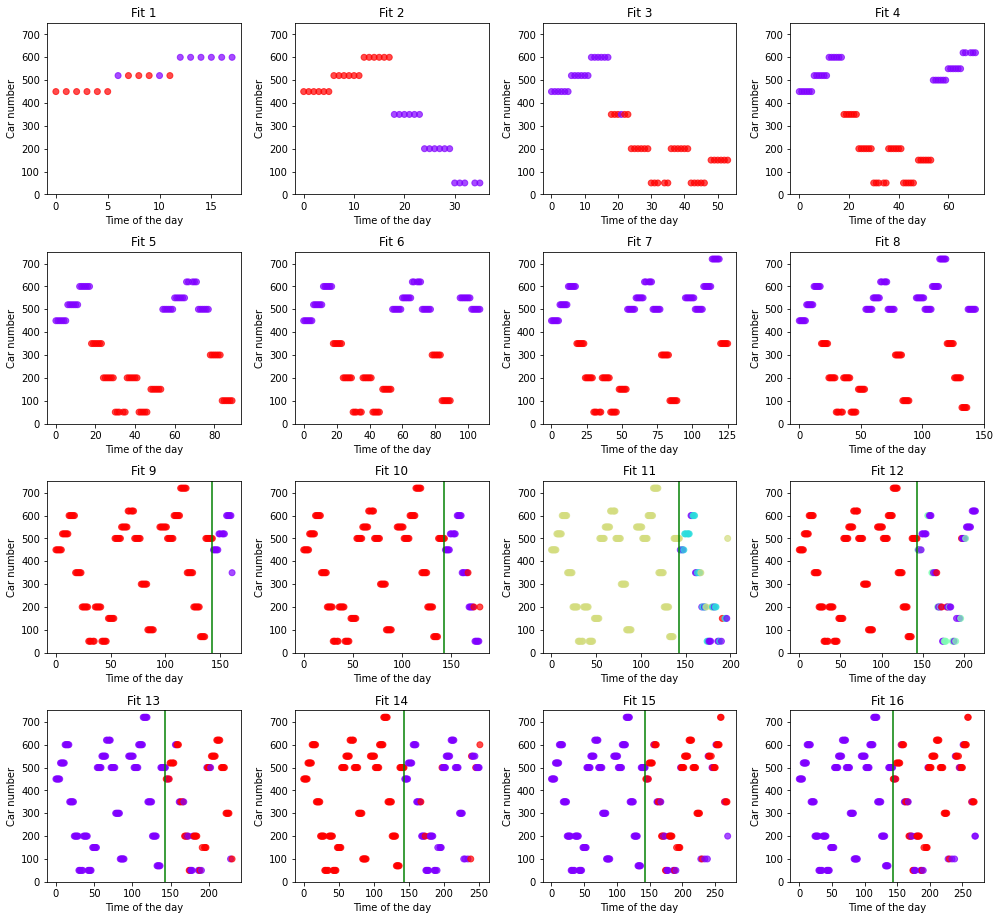

In [9]:
col_counter = 0
row_counter = 0

fit_number = 1

nrows = 4
ncols = 4

figure, axs = plt.subplots(nrows=nrows, ncols=ncols,figsize=(14,14))

for i in list_of_nmpys_for_graphs:
    
#     numpy_array = i.to_numpy()
    
    figure.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    axs[row_counter,col_counter].scatter(i[:, 5], i[:, 4], c =labels_dict[f'fit_{fit_number}'], cmap='rainbow', alpha=0.7 )
    axs[row_counter,col_counter].set_xlabel('Time of the day')
    axs[row_counter,col_counter].set_ylim(0, 750)
    axs[row_counter,col_counter].set_ylabel('Car number')
    axs[row_counter,col_counter].set_title(f'Fit {fit_number}')
    
    if fit_number >= 9:
        axs[row_counter,col_counter].axvline(x=143, color='g')
    if col_counter == (ncols-1):
        col_counter = 0
        row_counter += 1
    else:
        col_counter += 1
    
    fit_number += 1

In [10]:
for i in label_1_dict.values():
    print(i)
    
print('\n')

for i in label_0_dict.values():
    print(i)

10
18
33
34
46
46
52
63
136
139
26
17
57
144
78
78


8
17
19
35
41
54
66
73
16
30
16
42
154
81
160
161


In [11]:
model_001_before = Birch(n_clusters=None, threshold=0.01)

list_of_nmpys_for_graphs = []

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}
label_1_dict = {}
label_0_dict = {}
add_data_to_this = pd.DataFrame(columns = columns)

fit_number = 1

list_of_dfs

for i in range(0, len(list_of_dfs)):
    numpy_array = outliers_removal(list_of_dfs[i])
    
    model_001_before.partial_fit(numpy_array[:, :-2])
    
    model_copy = copy.deepcopy(model_001_before)
    
    removed_outliers_numpy.append(numpy_array)
    new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
    
    n = plot_silhouette_scores(model_copy, new_nmpy[:, :-2], 2, 10, fit_number)
#     print(n)
    
    model_copy.set_params(n_clusters = n)
    model_copy.partial_fit()
    
    labels_dict[f'fit_{fit_number}'] = model_copy.predict(new_nmpy[:, :-2])
    unique, counts = np.unique(labels_dict[f'fit_{fit_number}'], return_counts=True)
    label_1_dict[f'fit_{fit_number}'] = counts[1]
    label_0_dict[f'fit_{fit_number}'] = counts[0]
#     print(collections.Counter(labels_dict[f'fit_{fit_number}']))
#     print(get_cal_score(new_nmpy[:, :-2], labels_dict[f'fit_{fit_number}']))
    list_of_nmpys_for_graphs.append(new_nmpy)
    fit_number += 1
    
for i in label_1_dict.values():
    print(i)
    
print('\n')

for i in label_0_dict.values():
    print(i)

0.6324891906749939
0.5613479775590591
0.5722869255014478
0.6894222338566421
0.6934965659129884
0.7038640863596902
0.6683315672965646
0.6828786301110017
0.9433308235497124
0.9131609641624995
0.8883548535313004
0.8822880237072085
0.876114269231877
0.8663105479508371
0.8555311696868412
0.8546844276222594
8
10
26
34
46
46
52
63
136
139
140
140
140
144
144
144


10
10
18
35
41
54
66
73
16
30
43
59
71
81
94
95


/home/marta/env/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


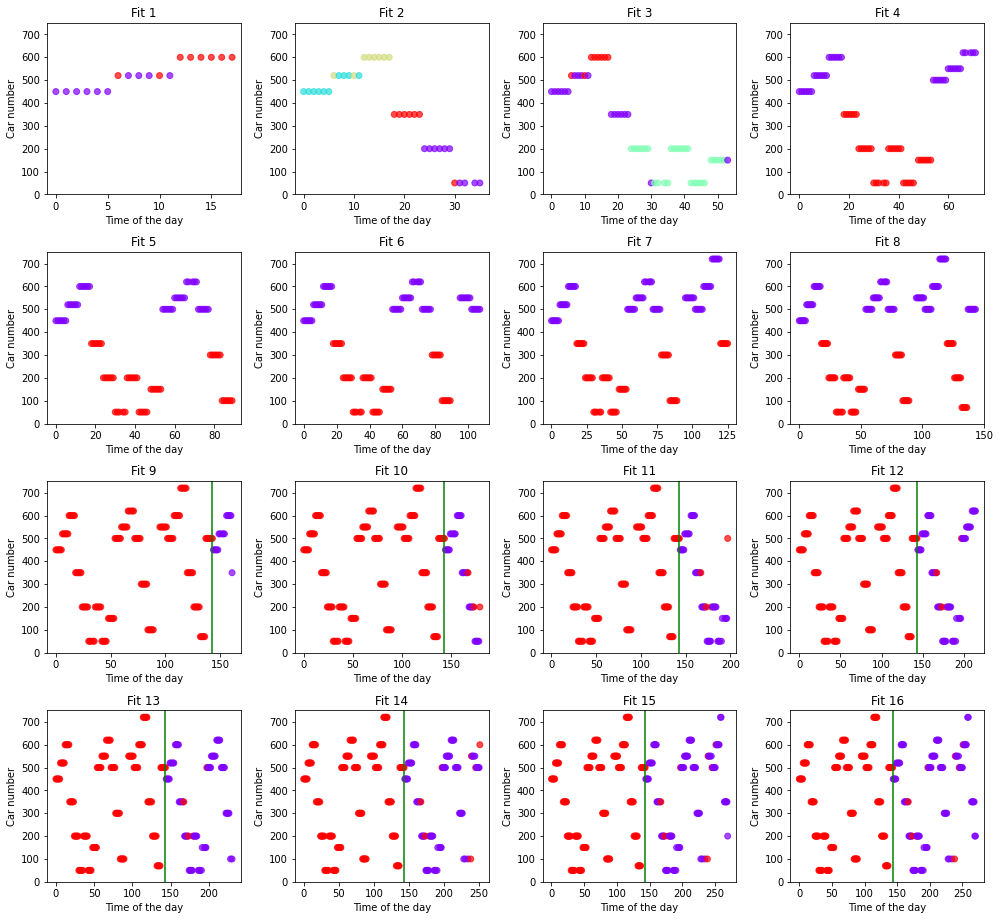

In [12]:
col_counter = 0
row_counter = 0

fit_number = 1

nrows = 4
ncols = 4

figure, axs = plt.subplots(nrows=nrows, ncols=ncols,figsize=(14,14))

for i in list_of_nmpys_for_graphs:
    
#     numpy_array = i.to_numpy()
    
    figure.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    axs[row_counter,col_counter].scatter(i[:, 5], i[:, 4], c =labels_dict[f'fit_{fit_number}'], cmap='rainbow', alpha=0.7 )
    axs[row_counter,col_counter].set_xlabel('Time of the day')
    axs[row_counter,col_counter].set_ylim(0, 750)
    axs[row_counter,col_counter].set_ylabel('Car number')
    axs[row_counter,col_counter].set_title(f'Fit {fit_number}')
    
    if fit_number >= 9:
        axs[row_counter,col_counter].axvline(x=143, color='g')
    if col_counter == (ncols-1):
        col_counter = 0
        row_counter += 1
    else:
        col_counter += 1
    
    fit_number += 1

In [13]:
model_005_before = Birch(n_clusters=None, threshold=0.05)

list_of_nmpys_for_graphs = []

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}
label_1_dict = {}
label_0_dict = {}
add_data_to_this = pd.DataFrame(columns = columns)

fit_number = 1

list_of_dfs

for i in range(0, len(list_of_dfs)):
    numpy_array = outliers_removal(list_of_dfs[i])
    
    model_005_before.partial_fit(numpy_array[:, :-2])
    
    model_copy = copy.deepcopy(model_005_before)
    
    removed_outliers_numpy.append(numpy_array)
    new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
    
    n = plot_silhouette_scores(model_copy, new_nmpy[:, :-2], 2, 10, fit_number)
#     print(n)
    
    model_copy.set_params(n_clusters = n)
    model_copy.partial_fit()
    
    labels_dict[f'fit_{fit_number}'] = model_copy.predict(new_nmpy[:, :-2])
    unique, counts = np.unique(labels_dict[f'fit_{fit_number}'], return_counts=True)
    label_1_dict[f'fit_{fit_number}'] = counts[1]
    label_0_dict[f'fit_{fit_number}'] = counts[0]
#     print(collections.Counter(labels_dict[f'fit_{fit_number}']))
#     print(get_cal_score(new_nmpy[:, :-2], labels_dict[f'fit_{fit_number}']))
    list_of_nmpys_for_graphs.append(new_nmpy)
    fit_number += 1
    
for i in label_0_dict.values():
    print(i)
    
print('\n')

for i in label_1_dict.values():
    print(i)

/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (7) by Birch is less than (8). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (7) by Birch is less than (9). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (7) by Birch is less than (10). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


0.6324891906749939
0.5988671904282449
0.6670738171217339
0.6894222338566421
0.6934965659129884
0.7038640863596902
0.6683315672965646
0.6828786301110017
0.9433308235497124
0.9131609641624995
0.8883548535313004
0.8822880237072085
0.876114269231877
0.8663105479508371
0.8555311696868412
0.8546844276222594
10
18
18
35
41
54
66
73
16
30
43
59
71
81
94
95


8
17
34
34
46
46
52
63
136
139
140
140
140
144
144
144


/home/marta/env/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


In [14]:
model_1_before = Birch(n_clusters=None, threshold=0.1)

list_of_nmpys_for_graphs = []

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}
label_1_dict = {}
label_0_dict = {}
add_data_to_this = pd.DataFrame(columns = columns)

fit_number = 1

list_of_dfs

for i in range(0, len(list_of_dfs)):
    numpy_array = outliers_removal(list_of_dfs[i])
    
    model_1_before.partial_fit(numpy_array[:, :-2])
    
    model_copy = copy.deepcopy(model_1_before)
    
    removed_outliers_numpy.append(numpy_array)
    new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
    
    n = plot_silhouette_scores(model_copy, new_nmpy[:, :-2], 2, 10, fit_number)
#     print(n)
    
    model_copy.set_params(n_clusters = n)
    model_copy.partial_fit()
    
    labels_dict[f'fit_{fit_number}'] = model_copy.predict(new_nmpy[:, :-2])
    unique, counts = np.unique(labels_dict[f'fit_{fit_number}'], return_counts=True)
    label_1_dict[f'fit_{fit_number}'] = counts[1]
    label_0_dict[f'fit_{fit_number}'] = counts[0]
#     print(collections.Counter(labels_dict[f'fit_{fit_number}']))
#     print(get_cal_score(new_nmpy[:, :-2], labels_dict[f'fit_{fit_number}']))
    list_of_nmpys_for_graphs.append(new_nmpy)
    fit_number += 1
    
for i in label_0_dict.values():
    print(i)
    
print('\n')

for i in label_1_dict.values():
    print(i)

0.6420626897753272
0.5719062337493854
0.6670738171217339
0.6894222338566421


/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (4) by Birch is less than (5). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (4) by Birch is less than (6). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (4) by Birch is less than (7). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning

0.6934965659129884
0.7038640863596902
0.6683315672965646
0.6828786301110017
0.9433308235497124
0.9131609641624995
0.8883548535313004
0.8822880237072085
0.876114269231877
0.8663105479508371
0.8555311696868412
0.8546844276222594
9
10
18
35
41
54
66
73
16
30
43
59
71
81
94
95


9
9
34
34
46
46
52
63
136
139
140
140
140
144
144
144


/home/marta/env/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


In [15]:
model_3_before = Birch(n_clusters=None, threshold=0.3)

list_of_nmpys_for_graphs = []

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}
label_1_dict = {}
label_0_dict = {}
add_data_to_this = pd.DataFrame(columns = columns)

fit_number = 1

list_of_dfs

for i in range(0, len(list_of_dfs)):
    numpy_array = outliers_removal(list_of_dfs[i])
    
    model_3_before.partial_fit(numpy_array[:, :-2])
    
    model_copy = copy.deepcopy(model_3_before)
    
    removed_outliers_numpy.append(numpy_array)
    new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
    
    n = plot_silhouette_scores(model_copy, new_nmpy[:, :-2], 2, 10, fit_number)
#     print(n)
    
    model_copy.set_params(n_clusters = n)
    model_copy.partial_fit()
    
    labels_dict[f'fit_{fit_number}'] = model_copy.predict(new_nmpy[:, :-2])
    unique, counts = np.unique(labels_dict[f'fit_{fit_number}'], return_counts=True)
    try:
        label_1_dict[f'fit_{fit_number}'] = counts[1]
    except:
        label_1_dict[f'fit_{fit_number}'] = 0
    label_0_dict[f'fit_{fit_number}'] = counts[0]
#     print(collections.Counter(labels_dict[f'fit_{fit_number}']))
#     print(get_cal_score(new_nmpy[:, :-2], labels_dict[f'fit_{fit_number}']))
    list_of_nmpys_for_graphs.append(new_nmpy)
    fit_number += 1
    
for i in label_0_dict.values():
    print(i)
    
print('\n')

for i in label_1_dict.values():
    print(i)

0
0.5859104763704347
0.6582427432425055
0.6894222338566421


/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (1) by Birch is less than (2). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (3). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (4). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning

0.6934965659129884
0.7038640863596902
0.6683315672965646
0.6828786301110017
0.9433308235497124


/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (3). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (4). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (5). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning

0.884338164831521
0.8544456330149754
0.8375566039859935
0.8128706204529009
0.8719539435309933
0.7831890622352349
0.7773705196579326
18
16
33
34
46
46
52
63
16
19
16
42
49
77
163
75


0
19
19
35
41
54
66
73
136
11
26
17
22
148
75
20


/home/marta/env/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


In [16]:
model_5_before = Birch(n_clusters=None, threshold=0.5)

list_of_nmpys_for_graphs = []

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}
label_1_dict = {}
label_0_dict = {}
add_data_to_this = pd.DataFrame(columns = columns)

fit_number = 1

list_of_dfs

for i in range(0, len(list_of_dfs)):
    numpy_array = outliers_removal(list_of_dfs[i])
    
    model_5_before.partial_fit(numpy_array[:, :-2])
    
    model_copy = copy.deepcopy(model_5_before)
    
    removed_outliers_numpy.append(numpy_array)
    new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
    
    n = plot_silhouette_scores(model_copy, new_nmpy[:, :-2], 2, 10, fit_number)
#     print(n)
    
    model_copy.set_params(n_clusters = n)
    model_copy.partial_fit()
    
    labels_dict[f'fit_{fit_number}'] = model_copy.predict(new_nmpy[:, :-2])
    unique, counts = np.unique(labels_dict[f'fit_{fit_number}'], return_counts=True)
    try:
        label_1_dict[f'fit_{fit_number}'] = counts[1]
    except:
        label_1_dict[f'fit_{fit_number}'] = 0
    label_0_dict[f'fit_{fit_number}'] = counts[0]
#     print(collections.Counter(labels_dict[f'fit_{fit_number}']))
#     print(get_cal_score(new_nmpy[:, :-2], labels_dict[f'fit_{fit_number}']))
    list_of_nmpys_for_graphs.append(new_nmpy)
    fit_number += 1
    
for i in label_0_dict.values():
    print(i)
    
print('\n')

for i in label_1_dict.values():
    print(i)

0
0
0
0
0
0
0
0
0.9433308235497124
0.884338164831521
0.8416477485053975


/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (1) by Birch is less than (2). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (1) by Birch is less than (2). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (1) by Birch is less than (2). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning

0.8236481674466628
0.7993857032181347
0.7782120047285952
0.7907265339719264
0.7825817000790704
18
35
52
69
87
100
118
136
16
19
143
143
48
148
162
163


0
0
0
0
0
0
0
0
136
11
26
41
143
54
76
76


/home/marta/env/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
